# Regresión lineal con series temporales

El objeto básico de la predicción son las series temporales, que son un conjunto de observaciones registradas a lo largo del tiempo. En las aplicaciones de pronóstico, las observaciones se registran con una frecuencia regular, como puede ser diaria o mensualmente.

In [2]:
import pandas as pd

df = pd.read_csv(
    "../data/book_sales.csv",
    index_col="Date",
    parse_dates=["Date"],
).drop("Paperback", axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


Esta serie registra el número de ventas de libros de tapa dura en una tienda durante 30 días. Por simplicidad, tiene una única columna de observaciones, `Hardcover` con un índice de tiempo `Date`.

Usaremos el algoritmo de regresión lineal para construir modelos predictivos. Estos algoritmos aprenden como hacer una suma ponderadas a partir de sus variables de entrada. Para dos variables tendríamos:

`objetivo = peso_1 * feature_1 + peso_2 + feature_2 + bias`

Durante el entrenamiento, el algoritmo de regresión aprende los valores para los parámetros `peso_1`, `peso_2` y `bias` que mejor ajustan el `objetivo`. A este algoritmo se le suele llamar *mínimos cuadrados ordinarios* ya que elige valores que minimizan el error cuadrático entre el objetivo y las predicciones. Los pesos también se denominan *coeficientes de regresión* y al `bias` también se le llama *intercept* porque nos dice dónde cruza el eje y la grafica de esta función.

### Features de paso de tiempo

Existen dos tipo de features únicas a las series temporales: las variables de paso de tiempo (*time-step*) y las variables de *lag*.

Las features de paso de tiempo son variables que se pueden derivar directamente del índice de tiempo. La feature de paso de tiempo más básica es la dummy, que cuenta el número de pasos de tiempo en las series desde el principio al final.

In [3]:
import numpy as np

df["Time"] = np.arange(len(df.index))

df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


La regresión lineal con el tiempo dummy produce el siguiente modelo:

`objetivo = peso * time + bias`

Text(0.5, 1.0, 'Ventas de libros')

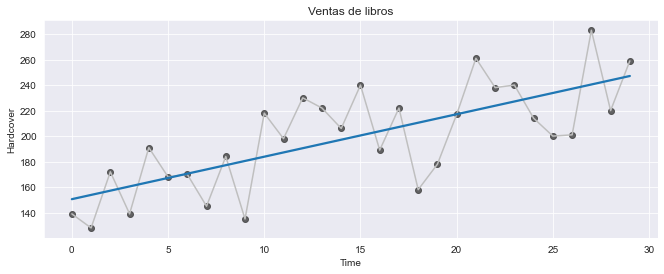

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 4))
ax.plot("Time", "Hardcover", data=df, color="0.75")
ax = sns.regplot(x="Time", y="Hardcover", data=df, ci=None,
                 scatter_kws=dict(color="0.25"))
ax.set_title("Ventas de libros")

Las features de paso de tiempo nos permiten modelar la **dependencia del tiempo**. Una serie es dependiente del tiempo si sus valores se pueden predecir desde el momento en que ocurrieron. En las serie de Hardcover, podemos predecir que las ventas al final de mes son generalmente más altas que las ventas al principio del mes.

### Features de *lag*

Para hacer una variable de *lag* deslizamos las observaciones de las series del objetivo para que parezcan haber ocurrido más tarde en el tiempo. Aquí hemos creado una variable lag de 1-paso, aunque también es posible desplazar en varios pasos.

In [5]:
df["Lag_1"] = df["Hardcover"].shift(1)
df = df.reindex(columns=["Hardcover", "Lag_1"])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


La regresión lineal con el la variable lag produce el siguiente modelo:

`objetivo = peso * lag + bias`

Entonces, las variables de lag nos permiten dibujar gráficas donde cada observación en una serie se dibuja contra la observación anterior.

Text(0.5, 1.0, 'Gráfico lag de Ventas')

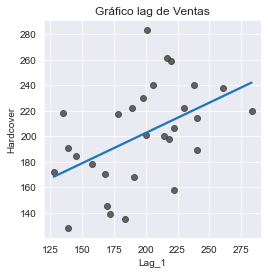

In [6]:
fig, ax = plt.subplots()
ax = sns.regplot(x="Lag_1", y="Hardcover", data=df, ci=None,
                 scatter_kws=dict(color="0.25"))
ax.set_aspect("equal")
ax.set_title("Gráfico lag de Ventas")

Podemos ver en el gráfico de lag que las ventas de un día (`Hardcover`) están correlacionadas con las ventas del día anterior (`Lag_1`). Cuando vemos una relación como ésta sabemos que una variable de lag será útil.

De forma más genérica, las features de lag nos permiten modelar la **dependencia en serie o serial**. Una serie temporal tiene dependencia serial cuando una observación se puede predecir a partir de la observaciones previas. En nuestro ejemplo, podemos predecir que ventas altas en un día, generalmente significan ventas altas en el siguiente día.

La adaptación de los algoritmos de machine learning a los problemas de series temporales se trata en gran medida con la ingeniería de features del índice de tiempo y los lags. Aunque estamos usando regresión lineal, estas variables serán útiles independientemente del algoritmo que seleccionemos para nuestras predicciones.

## Ejemplo - Tráfico túnel

El tráfico de túnel es una serie temporal que describe el número de vehículos que viajan a través del Túnel de Baregg en Suiza cada día desde noviembre 2002 a noviembre 2005. En este ejemplo, practicaremos aplicando regresión lineal a variables de paso de tiempo y variables lag.

In [7]:
tunnel = pd.read_csv(
    "../data/tunnel.csv",
    index_col="Day",
    parse_dates=["Day"])

tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


Por defecto, Pandas crea un `DatetimeIndex` cuyo tipo es `Timestamp`, equivalente a `np.datetime64`, representando una serie temporal como una secuencia de medidas tomadas en un determinado momento. un `PeriodIndex`, por otro lado, representa una serie temporal como una secuencia de cuantiles acumulados en periodos de tiempo. Los periodos suelen ser más fáciles de trabajar con ellos.

### Variable de paso de tiempo

Siempre que a la serie temporal no le falten fechas, podemos crear una time dummy contando la longitud de las series.

In [8]:
df = tunnel.copy()

df["Time"] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


Vamos a entrenar un modelo de regresión lineal.

In [9]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ["Time"]]
y = df.loc[:, "NumVehicles"]

model = LinearRegression()
model.fit(X, y)

# Almacena las predicciones como una serie temporal con el mismo
# índice de tiempo que los datos de entrenamiento
y_pred = pd.Series(model.predict(X), index=X.index)

In [10]:
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Length: 747, dtype: float64

Veamos cuáles son los coeficientes e intercept obtenidos:

In [11]:
model.coef_, model.intercept_

(array([22.49744953]), 98176.20634409295)

Por tanto, el modelo creado realmente es, aproximadamente,: `Vehicles = 22.5 * Time + 98176`. Al dibujar los valores obtenidos a lo largo del tiempo se muestra cómo la regresión lineal ajustada a la time dummy crea la línea de tendencia para esta ecuación.

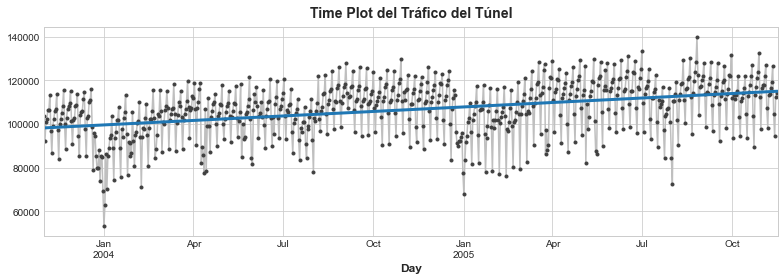

In [12]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot del Tráfico del Túnel');

### Variable lag

Pandas proporciona un método simple para "lagear" una serie, el método `shift`.

In [13]:
df["Lag_1"] = df["NumVehicles"].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


Cuando creamos variables lag, necesitamos decidir que hacer con los valores faltante que se generan. Una opción es rellenarlos, quizas con 0.0 ó con el primer valor conocido. En lugar de esto vamos a eliminar los valores faltantes, asegurándonos también de eliminar los valores en las fechas correspondiente del objetivo.

In [14]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ["Lag_1"]]
X.dropna(inplace=True)
y = df.loc[:, "NumVehicles"]
y, X = y.align(X, join="inner")

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

El diagrama de lag nos muestra cómo de bien somos capaces de ajustar la relación entre el número de vehículos de un día y el número del día anterior.

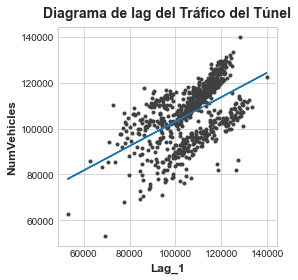

In [15]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Diagrama de lag del Tráfico del Túnel');

¿Qué significa esta predicción de la variable lag sobre cómo de bien puede predecir las series a lo largo del tiempo? El siguiente gráfico temporal nos muestra cómo nuestros pronósticos de ahora responden al comportamiento de las series del pasado reciente.

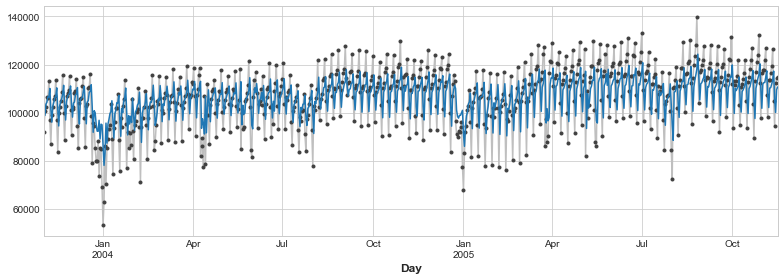

In [16]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

Los mejores modelos de series temporales normalmente incluirán alguna combinación entre variables de paso de tiempo y variables lag.

# Ejercicio

Vamos a realizar un ejercicio para ampliar lo que acabamos de ver. Para ello cargaremos algunos datasets.

In [17]:
book_sales = pd.read_csv(
    "../data/book_sales.csv",
    index_col="Date",
    parse_dates=["Date"],
).drop("Paperback", axis=1)
book_sales["Time"] = np.arange(len(book_sales.index))
book_sales["Lag_1"] = book_sales["Hardcover"].shift(1)
book_sales = book_sales.reindex(columns=["Hardcover", "Time", "Lag_1"])

book_sales.head()

,Hardcover,Time,Lag_1
Date,,,
2000-04-01,139,0,NaN
2000-04-02,128,1,139.0
2000-04-03,172,2,128.0
2000-04-04,139,3,172.0
2000-04-05,191,4,139.0


Una de las ventajas que tiene la regresión lineal sobre algoritmos más complicados es que los modelos que genera son *interpretables*, es decir, es fácil interpretar la contribución que hace cada feature a las predicciones. En el modelo `objetivo = peso * feature + bias`, el `peso` nos dice cuánto cambia el `objetivo` de media por cada unidad de cambio de la `feature`.

Vamos a ver la regresión lineal de las ventas de libros:

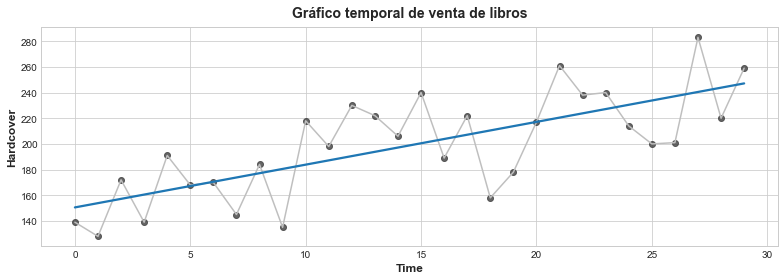

In [18]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Gráfico temporal de venta de libros');

## Interpretar la regresión lineal con *time dummy*

Digamos que la regresión lineal tiene una ecuación aproximada de: `Hardcover = 3.33 * Time + 150.5`. **Al cabo de 6 días, ¿cuánto se esperaría que cambiaran las ventas de libros?**

Si aplicamos la fórmula, entonces `3.33 * 6 + 150.5 = 19.98`. Luego se esperaría que las ventas sean de 19.98 libros. De acuerdo a este modelo, dado que la pendiente es 3.33, la venta de libros `Hardcover` cambiará de media 3.33 unidades por cada paso que cambie `Time`.

Interpretar los coeficientes de regresión puede ayudarnos a reconocer dependencias seriales en un gráfico temporal. Consideremos el modelo `objetivo = peso * lag_1 + error`, donde `error` es ruido aleatorio y `peso` es un número entre -1 y 1. En este caso, el `peso` nos dice cómo es de probable que el siguiente paso de tiempo tenga el mismo signo que el paso de tiempo anterior: un `peso` cercano a 1 significa que el `objetivo` probablemente tendrá el mismo signo que el paso previo, mientras que un `peso` cercano a -1 significa que el `objetivo` probablemente tendrá el signo opuesto.

## Interpretar la regresión lineal con una variable lag

Tenemos las siguientes dos series temporales:

In [19]:
ar = pd.read_csv("../data/ar.csv")

ar.head()

,ar1,ar2
0,0.541286,-1.234475
1,-1.692950,3.532498
2,-1.730106,-3.915508
3,-0.783524,2.820841
4,-1.796207,-1.084120


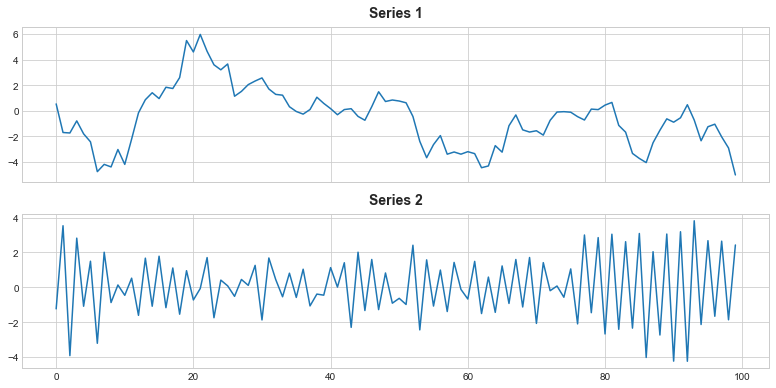

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

Una de estas series tiene la ecuación: `objetivo = 0.95 * lag_1 + error` y la otra tiene la ecuación `objetivo = -0.95 * lag_1 + error`, diferenciándose únicamente por el signo de la variable lag. **¿Qué ecuación correspondería a cada serie?**

La Serie 1 estaría generada por la ecuación `objetivo = 0.95 * lag_1 + error` y la Serie 2 estaría generada por la ecuación `objetivo = -0.95 * lag_1 + error`. Como explicamos anteriormente, la serie con el peso 0.95 (signo positivo) tenderá a tener valores con signos que permanecen iguales. La serie con el peso -0.95 (signo negativo) tenderá a tener valores con signos que van y vienen.
`

## Entrenar una variable de paso de tiempo

Vamos a cargar el dataset de la competición de Pronóstico de series temporales de ventas de almacén. El dataset completo contiene casi 1800 registrando las ventas de una amplia variedad de familias de productos desde 2013 a 2017. En principio solo trabajaremos con una única serie (`average_sales`) de las ventas medias por día.

In [21]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    "../data/store_sales/train.csv",
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [22]:
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [23]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

Vamos a crear un modelo de regresión lineal con una variable de paso de tiempo en la serie de promedio de ventas de producto. El objetivo es la columna `sales`.

In [24]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

# Crea time dummy
time = np.arange(len(df.index))

df['time'] = time

# Crea los datos de entrenamiento
X = df.loc[:, ["time"]]  # features
y = df.loc[:, "sales"]   # objetivo

# Entrena el modelo
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Vamos a dibujar la gráfica con el resultado:

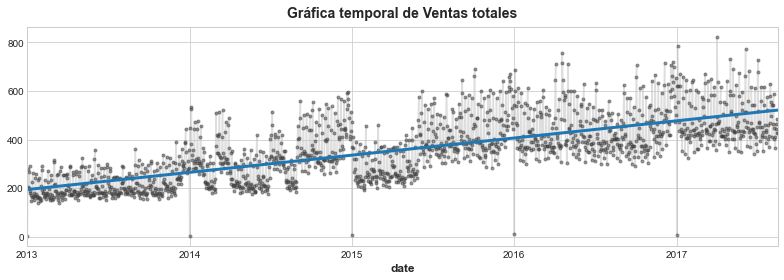

In [25]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Gráfica temporal de Ventas totales');

## Entrenar una variable lag

Vamos a crear un modelo de regresión lineal con una variable lag en la serie de promedio de ventas de producto. El objetivo es la columna `sales`.

In [26]:
df = average_sales.to_frame()

# Crea la variable lag
lag_1 = df["sales"].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']].dropna()   # features
y = df.loc[:, 'sales']              # target
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

Vamos a dibujar la gráfica con el resultado:

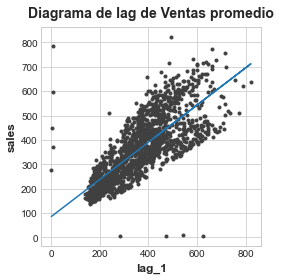

In [27]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Diagrama de lag de Ventas promedio');